In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import nltk
nltk.download("punkt")
from nltk.tokenize import word_tokenize

import torch
from torchtext.legacy.data import Field, LabelField, BucketIterator, TabularDataset

from utils import train_val_test_split

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


device(type='cuda')

DATASET

In [2]:
df = pd.read_csv('./data/train_data_restaurant.tsv', sep='\t', names=["review", "sentiment"])
df.head()

,review,sentiment
0,Saya makan di sini dengan menggunakan voucher ...,negative
1,Mas indosat buat main game enemy has been slai...,negative
2,Trus sy percuma dong update no hp terbaru ke c...,negative
3,jika kita pilih dia maka akan ada lebih dari 3...,negative
4,Dikarenakan adik saya suka dengan restoran ini...,negative


In [3]:
df = df.rename(columns={df.columns[0]:"TEXT", df.columns[1]:"LABEL"})
df.head()

,TEXT,LABEL
0,Saya makan di sini dengan menggunakan voucher ...,negative
1,Mas indosat buat main game enemy has been slai...,negative
2,Trus sy percuma dong update no hp terbaru ke c...,negative
3,jika kita pilih dia maka akan ada lebih dari 3...,negative
4,Dikarenakan adik saya suka dengan restoran ini...,negative


In [4]:
df.LABEL.value_counts()

positive    1200
negative     580
Name: LABEL, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TEXT    1780 non-null   object
 1   LABEL   1780 non-null   object
dtypes: object(2)
memory usage: 27.9+ KB


In [6]:
df.isna().sum()

TEXT     0
LABEL    0
dtype: int64

In [7]:
train, validation, test = train_val_test_split(df, train_size=0.8, val_size=0.1, random_state=42, frac=1)

print(len(train))
print(len(validation))
print(len(test))

1424
178
178


In [8]:
train.to_json("./data/train.json", orient="records", lines=True)
validation.to_json("./data/validation.json", orient="records", lines=True)
test.to_json("./data/test.json", orient="records", lines=True)

In [9]:
df["TEXT"][4]

'Dikarenakan adik saya suka dengan restoran ini, saya akhirnya mampir ke sini. Dari awal sih saya langsung tidak sreg sih. Makanan yang disediakan terlihat seperti yang tidak terlalu membangkitkan selera. Berbeda dengan restoran shabu yang biasa saya kunjungi. Dan setelah saya memilih dan mulai memasaknya, ternyata benar, rasanya pun tak masuk di lidah. Akhirnya banyak makanan yang tidak dimakan.'

In [10]:
def tokenize(text):
    return [tok for tok in word_tokenize(text)]

In [11]:
tokenize("Jika Anda tidak lagi mengonsumsi nasi dan sumber karbohidrat lainnya, hal ini bisa berdampak buruk pada tubuh.")

['Jika',
 'Anda',
 'tidak',
 'lagi',
 'mengonsumsi',
 'nasi',
 'dan',
 'sumber',
 'karbohidrat',
 'lainnya',
 ',',
 'hal',
 'ini',
 'bisa',
 'berdampak',
 'buruk',
 'pada',
 'tubuh',
 '.']

BUILD VOCAB

In [12]:
TEXT = Field(tokenize=tokenize, lower=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float)

fields = {"TEXT":("text", TEXT), "LABEL":("label", LABEL)}

In [13]:
train_data, valid_data, test_data = TabularDataset.splits(
    path="data",
    train = "train.json",
    validation = "validation.json",
    test = "test.json",
    format = "json",
    fields = fields
)

In [14]:
type(train_data)

torchtext.legacy.data.dataset.TabularDataset

In [15]:
print("Train.fields: ", train_data.fields)
print("Test.fields: ", test_data.fields)
print("valid.fields: ", valid_data.fields)

Train.fields:  {'text': <torchtext.legacy.data.field.Field object at 0x7eff388cd050>, 'label': <torchtext.legacy.data.field.LabelField object at 0x7eff388c7fd0>}
Test.fields:  {'text': <torchtext.legacy.data.field.Field object at 0x7eff388cd050>, 'label': <torchtext.legacy.data.field.LabelField object at 0x7eff388c7fd0>}
valid.fields:  {'text': <torchtext.legacy.data.field.Field object at 0x7eff388cd050>, 'label': <torchtext.legacy.data.field.LabelField object at 0x7eff388c7fd0>}


In [16]:
train_data[0].__dict__.keys()

dict_keys(['text', 'label'])

In [17]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 1424
Number of validation examples: 178
Number of testing examples: 178


In [18]:
print(vars(train_data.examples[6]))

{'text': ['buat', 'penyuka', 'daging', 'babi', ',', 'makan', 'mie', 'dengan', 'daging', 'babi', 'yang', 'diolah', 'di', 'bakmi', 'aloi', 'bisa', 'dipikirkan', 'untuk', 'dicoba', '.', 'tetapi', 'perlu', 'diingat', ',', 'mienya', 'adalah', 'mie', 'jadi', 'yang', 'boleh', 'beli', ',', 'bukan', 'bikin', ',', 'jadi', 'untuk', 'rasa', 'mie', ',', 'sepertinya', 'bisa', 'diabaikan', '.', 'rasa', 'dan', 'tekstur', 'daging', 'babinya', ',', 'bnaik', 'babi', 'chasiu', 'atau', 'babi', 'kecap', ',', 'boleh', 'masuk', 'daftar', 'menu', 'enak', '.'], 'label': 'positive'}


In [19]:
TEXT.build_vocab(train_data, max_size=10000)
LABEL.build_vocab(train_data, max_size=10000)

In [20]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key  = lambda x: len(x.text),
    device = device)

In [21]:
print(f"Unique tokens in text vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in label vocabulary: {len(LABEL.vocab)}")

Unique tokens in text vocabulary: 6855
Unique tokens in label vocabulary: 2


BUILD THE MODEL

In [22]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        embedded = self.dropout(self.embedding(text))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
            
        return self.fc(hidden)

SET CONFIG

In [23]:
!pip install jcopdl

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16924 sha256=d959e85631f562d0defdcf7dc004cc521ebd24e2ce47e6132d3fc21c146539b2
  Stored in directory: /root/.cache/pip/wheels/e5/78/9d/931694cba38491e16f1a94719193211fd12a7307570d9bb562
Successfully built jcopdl


In [24]:
from jcopdl.callback import set_config

In [25]:
len(TEXT.vocab)

6855

In [26]:
config = set_config({
    "INPUT_DIM":len(TEXT.vocab),
    "EMBEDDING_DIM":100,
    "HIDDEN_DIM":256,
    "OUTPUT_DIM":1,
    "N_LAYERS":2,
    "BIDIRECTIONAL":True,
    "DROPOUT":0.5,
    "PAD_IDX":TEXT.vocab.stoi[TEXT.pad_token]
})

In [27]:
model = RNN(config.INPUT_DIM, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.OUTPUT_DIM, config.N_LAYERS, 
            config.BIDIRECTIONAL, config.DROPOUT, config.PAD_IDX)

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,996,157 trainable parameters


Train Model

In [29]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

In [30]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [31]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
N_EPOCHS = 6

best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'sentiment_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.636 | Train Acc: 65.76%
	 Val. Loss: 0.553 |  Val. Acc: 73.42%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.557 | Train Acc: 70.65%
	 Val. Loss: 0.492 |  Val. Acc: 77.12%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.516 | Train Acc: 73.78%
	 Val. Loss: 0.513 |  Val. Acc: 77.71%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.442 | Train Acc: 79.69%
	 Val. Loss: 0.416 |  Val. Acc: 83.58%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.401 | Train Acc: 81.79%
	 Val. Loss: 0.421 |  Val. Acc: 83.35%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.366 | Train Acc: 83.97%
	 Val. Loss: 0.461 |  Val. Acc: 83.87%


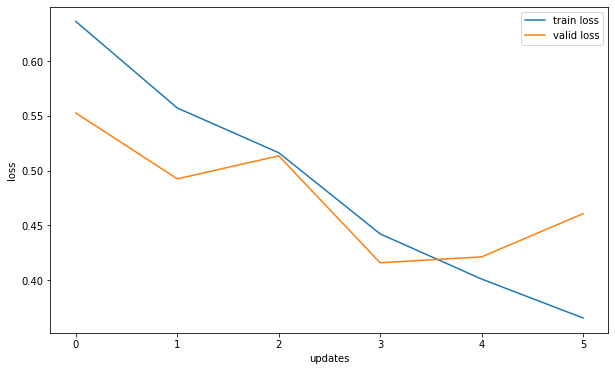

In [35]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

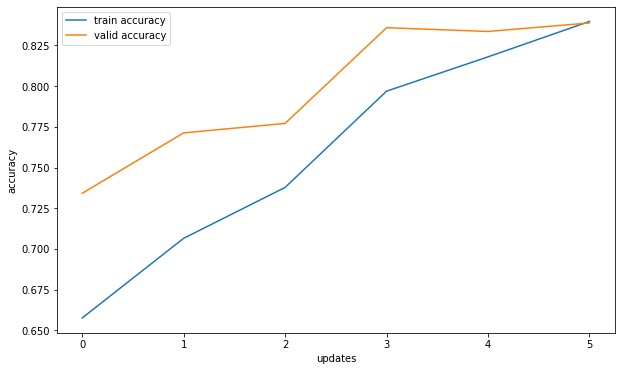

In [36]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [37]:
model.load_state_dict(torch.load('sentiment_model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.434 | Test Acc: 82.40%


In [76]:
torch.save(config, "config.pt")

In [77]:
torch.save(TEXT, "vocab.pt")

Predict

In [38]:
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok for tok in word_tokenize(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    
    return prediction.item()

In [75]:
predict_sentiment(model, "restorannya jelek")

0.33978989720344543